In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
print(os.getcwd())


/home/sagemaker-user


In [3]:
DATA_PATH = '/home/sagemaker-user/'

HMNIST_28_PATH = os.path.join(DATA_PATH, 'hmnist_28_28_RGB.csv')
HMNIST_8_PATH = os.path.join(DATA_PATH, 'hmnist_8_8_L.csv')
METADATA_PATH = os.path.join(DATA_PATH, 'HAM10000_metadata.csv')
IMAGES_PATH_1 = os.path.join(DATA_PATH, 'HAM10000_images_part_1')
IMAGES_PATH_2 = os.path.join(DATA_PATH, 'HAM10000_images_part_2')

In [4]:
metadata = pd.read_csv(METADATA_PATH)
metadata.shape

(10015, 7)

In [5]:
metadata['dx'].value_counts()


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [6]:
metadata.isnull().sum()


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [7]:
metadata = metadata.assign(
    age = metadata['age'].fillna(metadata['age'].median()),
    sex = metadata['sex'].map({'male': 1, 'female': 0, 'unknown': 0.5}).fillna(0.5)
)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
from sklearn.preprocessing import LabelEncoder

dx_encoder = LabelEncoder()
metadata['dx_encoded'] = dx_encoder.fit_transform(metadata['dx'])

dx_to_cancer_mapping = {
    'bcc': 2, 'mel': 2, 'scc': 2,  # malignant
    'akiec': 1,                    # precancer
    'bkl': 0, 'df': 0, 'nv': 0, 'vasc': 0  # benign + vasc added here
}

metadata['cancer_category'] = metadata['dx'].map(dx_to_cancer_mapping)



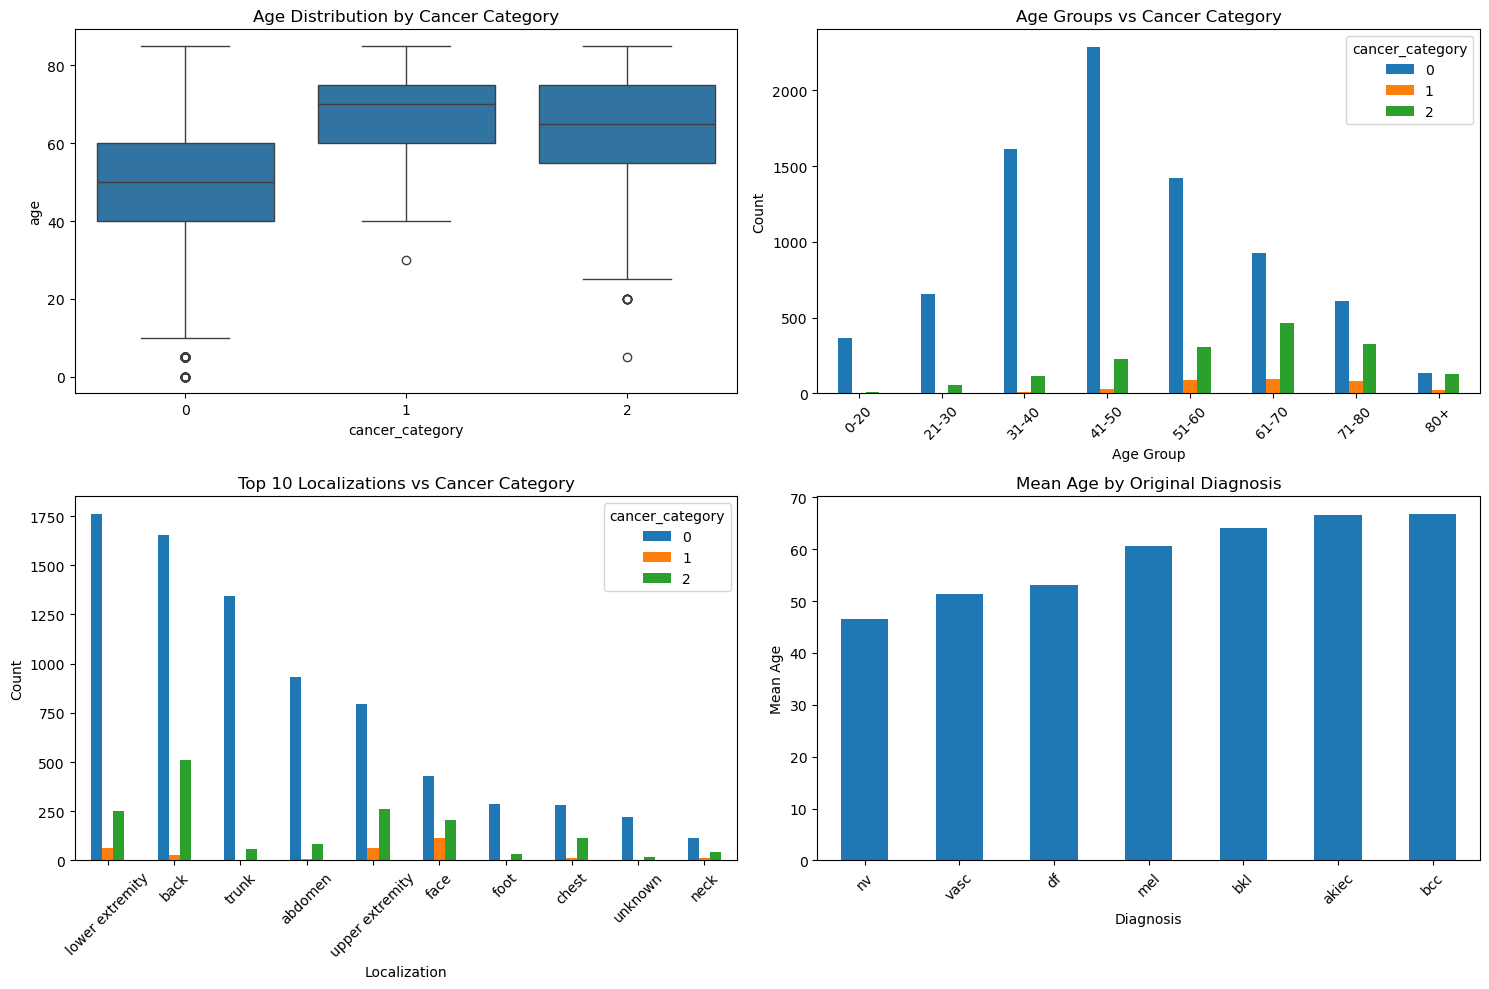

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 100]
metadata['age_group'] = pd.cut(metadata['age'], bins=age_bins, labels=['0-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+'])

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
localization_encoded = ohe.fit_transform(metadata[['localization']])
localization_df_raw = pd.DataFrame(localization_encoded, columns=[f'loc_{cat}' for cat in ohe.categories_[0]])

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data=metadata, x='cancer_category', y='age')
plt.title('Age Distribution by Cancer Category')

plt.subplot(2, 2, 2)
pd.crosstab(metadata['age_group'], metadata['cancer_category']).plot(kind='bar', rot=45, ax=plt.gca())
plt.title('Age Groups vs Cancer Category')
plt.xlabel('Age Group')
plt.ylabel('Count')

plt.subplot(2, 2, 3)
loc_crosstab = pd.crosstab(metadata['localization'], metadata['cancer_category'])
loc_crosstab.sort_values(by=0, ascending=False).head(10).plot(kind='bar', rot=45, ax=plt.gca())
plt.title('Top 10 Localizations vs Cancer Category')
plt.xlabel('Localization')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
metadata.groupby('dx')['age'].mean().sort_values().plot(kind='bar', rot=45, ax=plt.gca())
plt.title('Mean Age by Original Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Mean Age')

plt.tight_layout()
plt.show()


In [11]:
hmnist_28 = pd.read_csv(HMNIST_28_PATH)


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms

In [13]:
imagenet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

X_hmnist = hmnist_28.drop('label', axis=1).values
y_hmnist = hmnist_28['label'].values
X_hmnist = X_hmnist.reshape(-1, 28, 28, 3).transpose(0, 3, 1, 2)
X_hmnist = X_hmnist.astype(np.float32)

for i in range(len(X_hmnist)):
    X_hmnist[i] = imagenet_normalize(torch.tensor(X_hmnist[i] / 255.0)).numpy()
print(X_hmnist.shape)

X_train_hm, X_test_hm, y_train_hm, y_test_hm = train_test_split(
    X_hmnist, y_hmnist, test_size=0.2, random_state=42, stratify=y_hmnist
)
X_train_hm, X_val_hm, y_train_hm, y_val_hm = train_test_split(
    X_train_hm, y_train_hm, test_size=0.25, random_state=42, stratify=y_train_hm
)


(10015, 3, 28, 28)


In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class HMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.FloatTensor(self.images[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label

In [15]:
from sklearn.utils.class_weight import compute_class_weight

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model = SimpleCNN(len(np.unique(y_hmnist))).to(device)



In [16]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_hm), y=y_train_hm)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)


In [17]:
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-4)



In [18]:
train_dataset = HMNISTDataset(X_train_hm, y_train_hm)
val_dataset = HMNISTDataset(X_val_hm, y_val_hm)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [19]:
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=30):
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_acc = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            images, labels = images.to(device), labels.to(device)
            labels = labels.long().view(-1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.long().view(-1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_cnn_model.pth')

    return train_losses, val_losses, val_accuracies


In [20]:
train_losses, val_losses, val_accuracies = train_model(cnn_model, train_loader, val_loader, criterion, optimizer)


Epoch 1/30 - Train Loss: 1.8295, Val Loss: 1.7387, Val Acc: 47.78%


Epoch 2/30 - Train Loss: 1.7030, Val Loss: 1.6582, Val Acc: 49.93%


Epoch 3/30 - Train Loss: 1.6289, Val Loss: 1.6012, Val Acc: 49.38%


Epoch 4/30 - Train Loss: 1.6120, Val Loss: 1.5413, Val Acc: 51.92%


Epoch 5/30 - Train Loss: 1.5379, Val Loss: 1.5339, Val Acc: 43.73%


Epoch 6/30 - Train Loss: 1.4569, Val Loss: 1.4033, Val Acc: 53.07%


Epoch 7/30 - Train Loss: 1.4132, Val Loss: 1.3629, Val Acc: 53.17%


Epoch 8/30 - Train Loss: 1.3774, Val Loss: 1.3633, Val Acc: 53.72%


Epoch 9/30 - Train Loss: 1.3203, Val Loss: 1.2923, Val Acc: 54.42%


Epoch 10/30 - Train Loss: 1.3175, Val Loss: 1.3160, Val Acc: 53.22%


Epoch 11/30 - Train Loss: 1.2856, Val Loss: 1.2617, Val Acc: 50.77%


Epoch 12/30 - Train Loss: 1.2504, Val Loss: 1.2385, Val Acc: 54.87%


Epoch 13/30 - Train Loss: 1.2596, Val Loss: 1.2576, Val Acc: 52.07%


Epoch 14/30 - Train Loss: 1.2554, Val Loss: 1.2388, Val Acc: 53.52%


Epoch 15/30 - Train Loss: 1.2255, Val Loss: 1.2357, Val Acc: 55.92%


Epoch 16/30 - Train Loss: 1.2174, Val Loss: 1.2374, Val Acc: 54.82%


Epoch 17/30 - Train Loss: 1.2138, Val Loss: 1.2543, Val Acc: 58.91%


Epoch 18/30 - Train Loss: 1.1862, Val Loss: 1.2229, Val Acc: 57.21%


Epoch 19/30 - Train Loss: 1.1951, Val Loss: 1.2317, Val Acc: 55.77%


Epoch 20/30 - Train Loss: 1.1670, Val Loss: 1.1730, Val Acc: 55.17%


Epoch 21/30 - Train Loss: 1.1809, Val Loss: 1.1797, Val Acc: 56.96%


Epoch 22/30 - Train Loss: 1.1514, Val Loss: 1.1806, Val Acc: 59.26%


Epoch 23/30 - Train Loss: 1.1453, Val Loss: 1.1690, Val Acc: 56.67%


Epoch 24/30 - Train Loss: 1.1345, Val Loss: 1.1705, Val Acc: 57.76%


Epoch 25/30 - Train Loss: 1.1097, Val Loss: 1.1694, Val Acc: 55.52%


Epoch 26/30 - Train Loss: 1.1142, Val Loss: 1.1974, Val Acc: 59.96%


Epoch 27/30 - Train Loss: 1.1099, Val Loss: 1.1586, Val Acc: 61.11%


Epoch 28/30 - Train Loss: 1.0993, Val Loss: 1.1655, Val Acc: 60.96%


Epoch 29/30 - Train Loss: 1.0846, Val Loss: 1.1537, Val Acc: 55.87%


Epoch 30/30 - Train Loss: 1.0731, Val Loss: 1.1907, Val Acc: 56.52%


In [21]:
from PIL import Image
import numpy as np

def load_ham_images():
    image_data = []
    image_labels = []
    image_labels_7class = []
    tabular_data = []

    for idx, row in metadata.iterrows():
        img_path = os.path.join(IMAGES_PATH_1, f"{row['image_id']}.jpg")
        if not os.path.exists(img_path):
            img_path = os.path.join(IMAGES_PATH_2, f"{row['image_id']}.jpg")

        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            img = img.resize((224, 224))
            img = np.array(img).astype(np.float32) / 255.0
            img = img.transpose(2, 0, 1)

            image_data.append(img)
            image_labels.append(row['cancer_category'])
            image_labels_7class.append(row['dx_encoded'])

            tabular_features = [row['age'], row['sex']] + localization_encoded[idx].tolist()
            tabular_data.append(tabular_features)

    return np.array(image_data), np.array(image_labels), np.array(image_labels_7class), np.array(tabular_data)


In [22]:
X_images, y_labels_3class, y_labels_7class, X_tabular = load_ham_images()

In [23]:
from sklearn.preprocessing import StandardScaler

scaler_full = StandardScaler()
X_tabular_scaled = scaler_full.fit_transform(X_tabular)

X_img_train, X_img_temp, X_tab_train, X_tab_temp, y_train_3, y_temp_3, y_train_7, y_temp_7 = train_test_split(
    X_images, X_tabular_scaled, y_labels_3class, y_labels_7class,
    test_size=0.3, random_state=42, stratify=y_labels_7class
)
X_img_val, X_img_test, X_tab_val, X_tab_test, y_val_3, y_test_3, y_val_7, y_test_7 = train_test_split(
    X_img_temp, X_tab_temp, y_temp_3, y_temp_7,
    test_size=0.5, random_state=42, stratify=y_temp_7
)

In [24]:
import torchvision.models as models

class DualInputModel(nn.Module):
    def __init__(self, tabular_features, num_classes, pretrained=True):
        super(DualInputModel, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=pretrained)

        for param in self.efficientnet.parameters():
            param.requires_grad = False

        self.efficientnet.classifier = nn.Identity()

        self.image_fc = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.tabular_fc = nn.Sequential(
            nn.Linear(tabular_features, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU()
        )

        self.combined_fc = nn.Sequential(
            nn.Linear(256 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, image, tabular):
        img_features = self.efficientnet(image)
        img_features = self.image_fc(img_features)

        tab_features = self.tabular_fc(tabular)

        combined = torch.cat([img_features, tab_features], dim=1)
        output = self.combined_fc(combined)

        return output


In [25]:
dual_model = DualInputModel(X_tabular_scaled.shape[1], 7).to(device)


/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
class DualDataset(Dataset):
    def __init__(self, images, tabular, labels, transform=None):
        self.images = images
        self.tabular = torch.FloatTensor(tabular)
        self.labels = torch.LongTensor(labels)
        self.transform = transform
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.FloatTensor(self.images[idx])

        if self.transform:
            image = self.transform(image)

        image = self.normalize(image)
        return image, self.tabular[idx], self.labels[idx]


In [27]:
class_weights_7class = compute_class_weight('balanced', classes=np.unique(y_train_7), y=y_train_7)
class_weights_7class_tensor = torch.FloatTensor(class_weights_7class).to(device)


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05)
])

criterion_7class = nn.CrossEntropyLoss()
optimizer_dual = torch.optim.Adam(dual_model.parameters(), lr=1e-4, weight_decay=1e-5)

train_dataset_dual = DualDataset(X_img_train, X_tab_train, y_train_7, transform=train_transform)
val_dataset_dual = DualDataset(X_img_val, X_tab_val, y_val_7)

train_loader_dual = DataLoader(train_dataset_dual, batch_size=8, shuffle=True)
val_loader_dual = DataLoader(val_dataset_dual, batch_size=8)

from torch.utils.data import WeightedRandomSampler

class_counts = np.bincount(y_train_7)
class_weights = 1.0 / class_counts
sample_weights = [class_weights[t] for t in y_train_7]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader_dual = DataLoader(train_dataset_dual, batch_size=16, sampler=sampler)
val_loader_dual = DataLoader(val_dataset_dual, batch_size=16)


In [28]:
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score

def train_dual_model(model, train_loader, val_loader, criterion, optimizer, epochs=15):
    train_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0
    patience = 8
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, tabular, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)
            labels = labels.long().view(-1)

            optimizer.zero_grad()
            outputs = model(images, tabular)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, tabular, labels in val_loader:
                images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)
                labels = labels.long().view(-1)
                outputs = model(images, tabular)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_dual_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return train_losses, val_losses, val_accuracies, []



In [29]:
dual_train_losses, dual_val_losses, dual_val_accuracies, dual_val_f1_scores = train_dual_model(
    dual_model, train_loader_dual, val_loader_dual, criterion_7class, optimizer_dual, epochs=20
)


Epoch 1/20 | Train Loss: 1.8977 | Val Loss: 1.8762 | Val Acc: 27.58%


Epoch 2/20 | Train Loss: 1.6536 | Val Loss: 1.5379 | Val Acc: 53.48%


Epoch 3/20 | Train Loss: 1.3668 | Val Loss: 1.3180 | Val Acc: 57.07%


Epoch 4/20 | Train Loss: 1.2104 | Val Loss: 1.3144 | Val Acc: 54.20%


Epoch 5/20 | Train Loss: 1.1025 | Val Loss: 1.1435 | Val Acc: 60.19%


Epoch 6/20 | Train Loss: 1.0095 | Val Loss: 1.1543 | Val Acc: 62.83%


Epoch 7/20 | Train Loss: 0.9828 | Val Loss: 1.0651 | Val Acc: 64.27%


Epoch 8/20 | Train Loss: 0.9142 | Val Loss: 0.9951 | Val Acc: 66.43%


Epoch 9/20 | Train Loss: 0.8916 | Val Loss: 1.0707 | Val Acc: 65.23%


Epoch 10/20 | Train Loss: 0.8631 | Val Loss: 1.0147 | Val Acc: 69.30%


Epoch 11/20 | Train Loss: 0.7841 | Val Loss: 0.9156 | Val Acc: 71.94%


Epoch 12/20 | Train Loss: 0.8047 | Val Loss: 0.9962 | Val Acc: 68.35%


Epoch 13/20 | Train Loss: 0.7436 | Val Loss: 0.9272 | Val Acc: 70.02%


Epoch 14/20 | Train Loss: 0.7271 | Val Loss: 0.9186 | Val Acc: 68.82%


Epoch 15/20 | Train Loss: 0.7391 | Val Loss: 0.8625 | Val Acc: 72.42%


Epoch 16/20 | Train Loss: 0.7187 | Val Loss: 0.8655 | Val Acc: 71.46%


Epoch 17/20 | Train Loss: 0.7489 | Val Loss: 0.8735 | Val Acc: 71.94%


Epoch 18/20 | Train Loss: 0.6820 | Val Loss: 0.8124 | Val Acc: 73.14%


Epoch 19/20 | Train Loss: 0.6634 | Val Loss: 0.8834 | Val Acc: 69.54%


Epoch 20/20 | Train Loss: 0.6246 | Val Loss: 0.8348 | Val Acc: 72.42%


In [33]:
def train_dual_model(model, train_loader, val_loader, criterion, optimizer, epochs=15):
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []  
    best_val_acc = 0
    patience = 8
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, tabular, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)
            labels = labels.long().view(-1)

            optimizer.zero_grad()
            outputs = model(images, tabular)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = [] 
        all_labels = [] 

        with torch.no_grad():
            for images, tabular, labels in val_loader:
                images, tabular, labels = images.to(device), tabular.to(device), labels.to(device)
                labels = labels.long().view(-1)
                outputs = model(images, tabular)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Collect for F1 calculation
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_acc = 100 * correct / total
        val_f1 = f1_score(all_labels, all_preds, average='macro')  # Calculate F1 score
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)  # Append F1 score

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}% | "
              f"Val F1: {val_f1:.4f}")  # Print F1 score

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_dual_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return train_losses, val_losses, val_accuracies, val_f1_scores 


In [34]:
finetune_train_losses, finetune_val_losses, finetune_val_accuracies, finetune_f1_scores = gradual_unfreeze_finetune(
    dual_model, train_loader_dual, val_loader_dual, criterion_7class
)


Starting gradual fine-tuning with 4 stages

Stage 1/4: Unfreezing Block 7
Learning Rate: 1e-05
Unfrozen 13 parameter groups
Total trainable parameters: 3,112,643
----------------------------------------


Epoch 1/8 | Train Loss: 0.5559 | Val Loss: 0.8149 | Val Acc: 71.46% | Val F1: 0.4801


Epoch 2/8 | Train Loss: 0.5488 | Val Loss: 0.8334 | Val Acc: 71.94% | Val F1: 0.4919


Epoch 3/8 | Train Loss: 0.5472 | Val Loss: 0.7677 | Val Acc: 72.18% | Val F1: 0.4882


Epoch 4/8 | Train Loss: 0.5188 | Val Loss: 0.7865 | Val Acc: 73.14% | Val F1: 0.4878


Epoch 5/8 | Train Loss: 0.5216 | Val Loss: 0.8078 | Val Acc: 73.14% | Val F1: 0.5042


Epoch 6/8 | Train Loss: 0.5117 | Val Loss: 0.8165 | Val Acc: 73.38% | Val F1: 0.5175


Epoch 7/8 | Train Loss: 0.4943 | Val Loss: 0.7339 | Val Acc: 75.30% | Val F1: 0.5511


Epoch 8/8 | Train Loss: 0.4924 | Val Loss: 0.7506 | Val Acc: 74.58% | Val F1: 0.5186
Stage 1 completed:
  Best Accuracy: 75.30%
  Best F1: 0.5511
  New best accuracy achieved! Saved as best_stage_1_model.pth

Stage 2/4: Unfreezing Block 6
Learning Rate: 8e-06
Unfrozen 52 parameter groups
Total trainable parameters: 3,112,643
----------------------------------------


Epoch 1/8 | Train Loss: 0.4829 | Val Loss: 0.7518 | Val Acc: 74.58% | Val F1: 0.5252


Epoch 2/8 | Train Loss: 0.4751 | Val Loss: 0.7039 | Val Acc: 75.78% | Val F1: 0.5337


Epoch 3/8 | Train Loss: 0.4933 | Val Loss: 0.7632 | Val Acc: 73.86% | Val F1: 0.5166


Epoch 4/8 | Train Loss: 0.4633 | Val Loss: 0.7191 | Val Acc: 75.30% | Val F1: 0.5375


Epoch 5/8 | Train Loss: 0.4458 | Val Loss: 0.7696 | Val Acc: 73.86% | Val F1: 0.5098


Epoch 6/8 | Train Loss: 0.4556 | Val Loss: 0.7613 | Val Acc: 73.86% | Val F1: 0.5230


Epoch 7/8 | Train Loss: 0.4569 | Val Loss: 0.7075 | Val Acc: 75.78% | Val F1: 0.5354


Epoch 8/8 | Train Loss: 0.4245 | Val Loss: 0.7350 | Val Acc: 75.06% | Val F1: 0.5453
Stage 2 completed:
  Best Accuracy: 75.78%
  Best F1: 0.5453
  New best accuracy achieved! Saved as best_stage_2_model.pth

Stage 3/4: Unfreezing Block 5
Learning Rate: 5e-06
Unfrozen 39 parameter groups
Total trainable parameters: 3,655,791
----------------------------------------


Epoch 1/8 | Train Loss: 0.4064 | Val Loss: 0.7524 | Val Acc: 74.34% | Val F1: 0.5214


Epoch 2/8 | Train Loss: 0.4161 | Val Loss: 0.7275 | Val Acc: 75.06% | Val F1: 0.5632


Epoch 3/8 | Train Loss: 0.4193 | Val Loss: 0.7132 | Val Acc: 75.78% | Val F1: 0.5472


Epoch 4/8 | Train Loss: 0.4054 | Val Loss: 0.7336 | Val Acc: 75.30% | Val F1: 0.5310


Epoch 5/8 | Train Loss: 0.4212 | Val Loss: 0.7005 | Val Acc: 75.78% | Val F1: 0.5358


Epoch 6/8 | Train Loss: 0.3915 | Val Loss: 0.7111 | Val Acc: 75.54% | Val F1: 0.5509


Epoch 7/8 | Train Loss: 0.3829 | Val Loss: 0.7339 | Val Acc: 75.06% | Val F1: 0.5494


Epoch 8/8 | Train Loss: 0.3818 | Val Loss: 0.6871 | Val Acc: 76.02% | Val F1: 0.5827
Stage 3 completed:
  Best Accuracy: 76.02%
  Best F1: 0.5827
  New best accuracy achieved! Saved as best_stage_3_model.pth

Stage 4/4: Unfreezing Block 4
Learning Rate: 3e-06
Unfrozen 39 parameter groups
Total trainable parameters: 3,898,721
----------------------------------------


Epoch 1/8 | Train Loss: 0.3890 | Val Loss: 0.6937 | Val Acc: 75.78% | Val F1: 0.5460


Epoch 2/8 | Train Loss: 0.3781 | Val Loss: 0.7185 | Val Acc: 74.58% | Val F1: 0.5455


Epoch 3/8 | Train Loss: 0.3895 | Val Loss: 0.6951 | Val Acc: 75.54% | Val F1: 0.5749


Epoch 4/8 | Train Loss: 0.3511 | Val Loss: 0.6985 | Val Acc: 75.78% | Val F1: 0.5525


Epoch 5/8 | Train Loss: 0.3700 | Val Loss: 0.6946 | Val Acc: 74.58% | Val F1: 0.5278


Epoch 6/8 | Train Loss: 0.3818 | Val Loss: 0.6717 | Val Acc: 76.98% | Val F1: 0.5621


Epoch 7/8 | Train Loss: 0.3457 | Val Loss: 0.6961 | Val Acc: 75.06% | Val F1: 0.5402


Epoch 8/8 | Train Loss: 0.3680 | Val Loss: 0.7100 | Val Acc: 75.06% | Val F1: 0.5725
Stage 4 completed:
  Best Accuracy: 76.98%
  Best F1: 0.5749
  New best accuracy achieved! Saved as best_stage_4_model.pth
FINE-TUNING COMPLETED
Overall Best Accuracy: 76.98%
Overall Best F1 Score: 0.5827
Total epochs completed: 32
Final model saved as: best_dual_model_finetuned_final.pth


In [35]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve, precision_recall_curve

dx_to_cancer_array = np.array([dx_to_cancer_mapping[dx] for dx in dx_encoder.classes_])

def evaluate_pytorch_model(model, images, tabular, y_true_7, y_true_3, dataset_name):
    model.eval()
    all_probs = []
    all_preds = []

    dataset = DualDataset(images, tabular, y_true_7)
    loader = DataLoader(dataset, batch_size=16)

    with torch.no_grad():
        for img_batch, tab_batch, _ in loader:
            img_batch, tab_batch = img_batch.to(device), tab_batch.to(device)
            outputs = model(img_batch, tab_batch)
            probs = F.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())

    y_pred_proba_7 = np.array(all_probs)
    y_pred_7 = np.array(all_preds)

    y_pred_3 = dx_to_cancer_array[y_pred_7]

    accuracy_7 = np.mean(y_pred_7 == y_true_7)
    accuracy_3 = np.mean(y_pred_3 == y_true_3)
    f1_macro_7 = f1_score(y_true_7, y_pred_7, average='macro')
    f1_macro_3 = f1_score(y_true_3, y_pred_3, average='macro')

    auc_macro_7 = roc_auc_score(y_true_7, y_pred_proba_7, multi_class='ovr', average='macro')

    metrics = {
        'dataset': dataset_name,
        'accuracy_7class': accuracy_7,
        'accuracy_3class': accuracy_3,
        'f1_macro_7class': f1_macro_7,
        'f1_macro_3class': f1_macro_3,
        'auc_macro_7class': auc_macro_7
    }

    plt.figure(figsize=(20, 10))
    plt.subplot(2, 4, 1)
    cm_7 = confusion_matrix(y_true_7, y_pred_7)
    sns.heatmap(cm_7, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix 7-Class - {dataset_name}')

    plt.subplot(2, 4, 2)
    cm_3 = confusion_matrix(y_true_3, y_pred_3)
    sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix 3-Class - {dataset_name}')

    plt.subplot(2, 4, 3)
    for i in range(7):
        if np.sum(y_true_7 == i) > 0:
            fpr, tpr, _ = roc_curve((y_true_7 == i).astype(int), y_pred_proba_7[:, i])
            plt.plot(fpr, tpr, label=f'Class {i}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves 7-Class - {dataset_name}')
    plt.legend()

    plt.subplot(2, 4, 4)
    for i in range(7):
        if np.sum(y_true_7 == i) > 0:
            precision, recall, _ = precision_recall_curve((y_true_7 == i).astype(int), y_pred_proba_7[:, i])
            plt.plot(recall, precision, label=f'Class {i}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'PR Curves 7-Class - {dataset_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return metrics



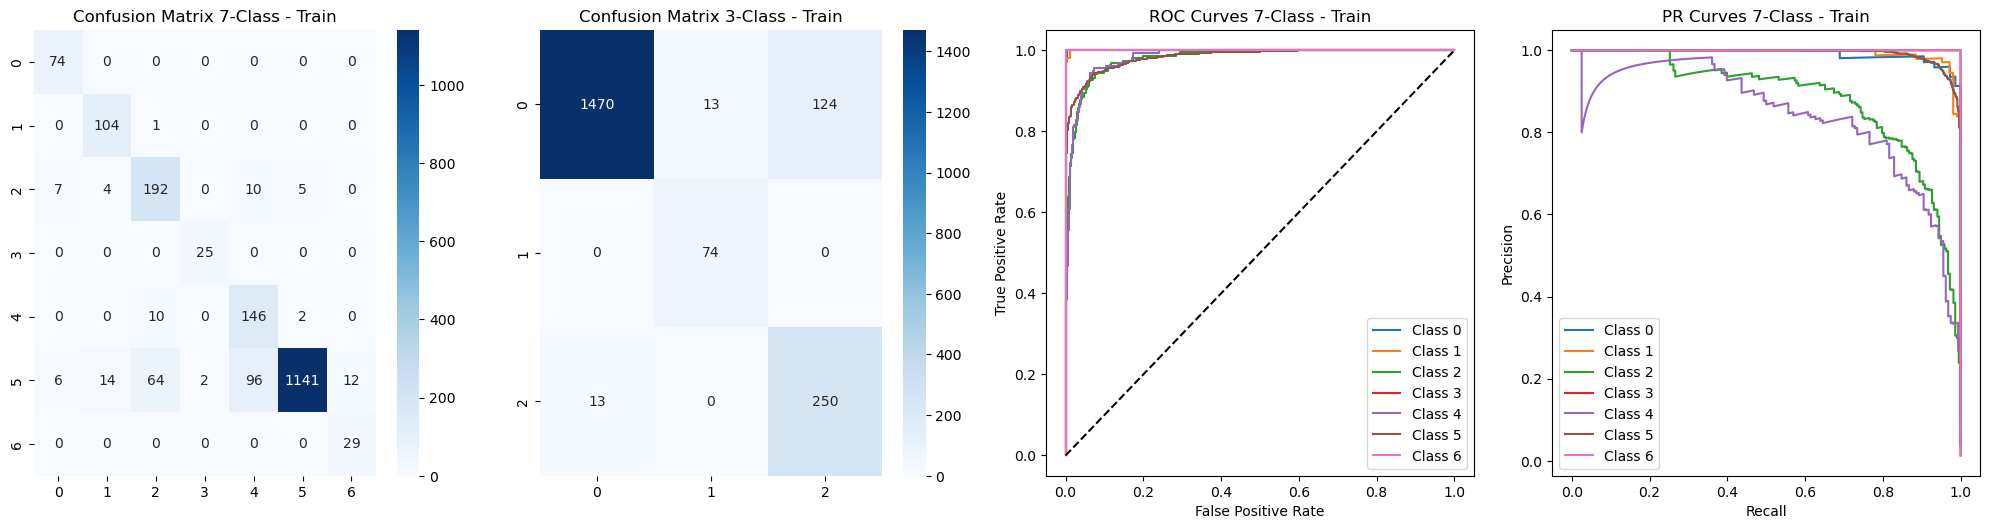

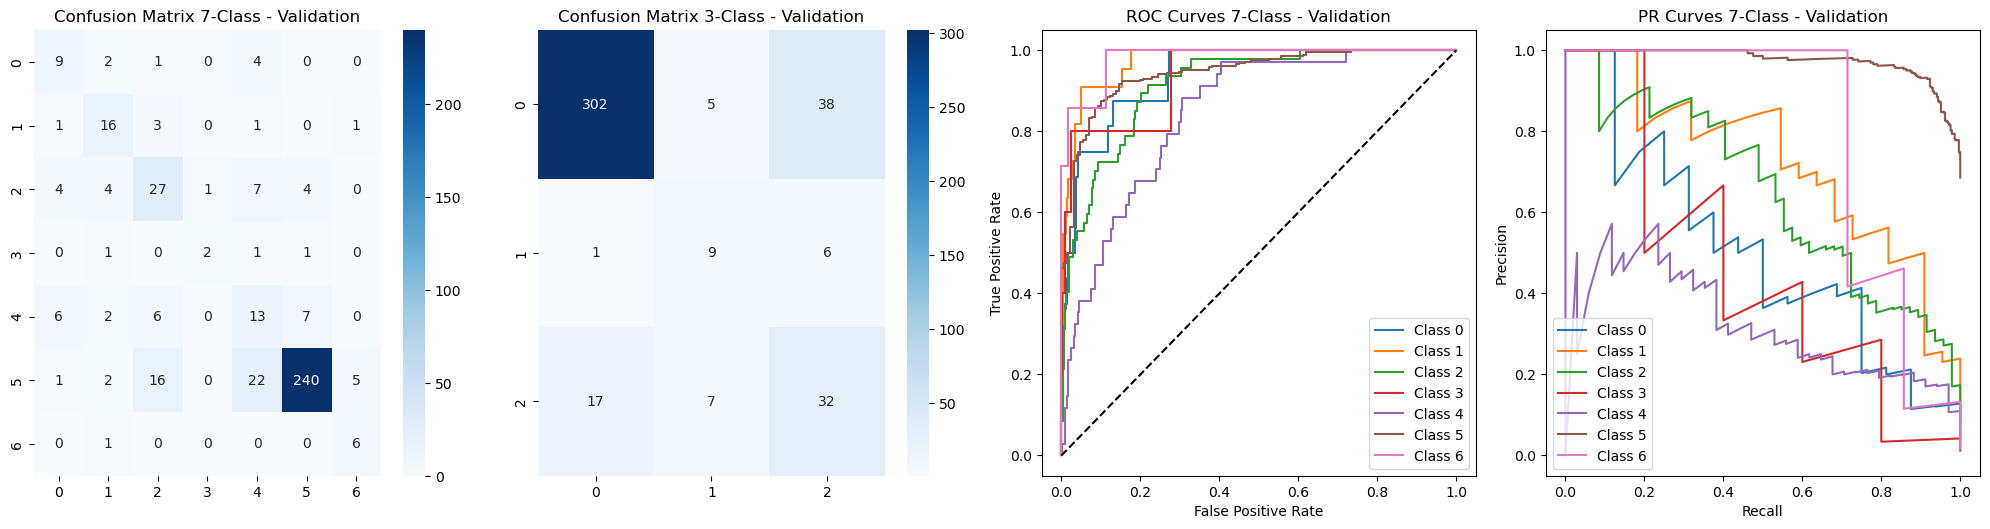

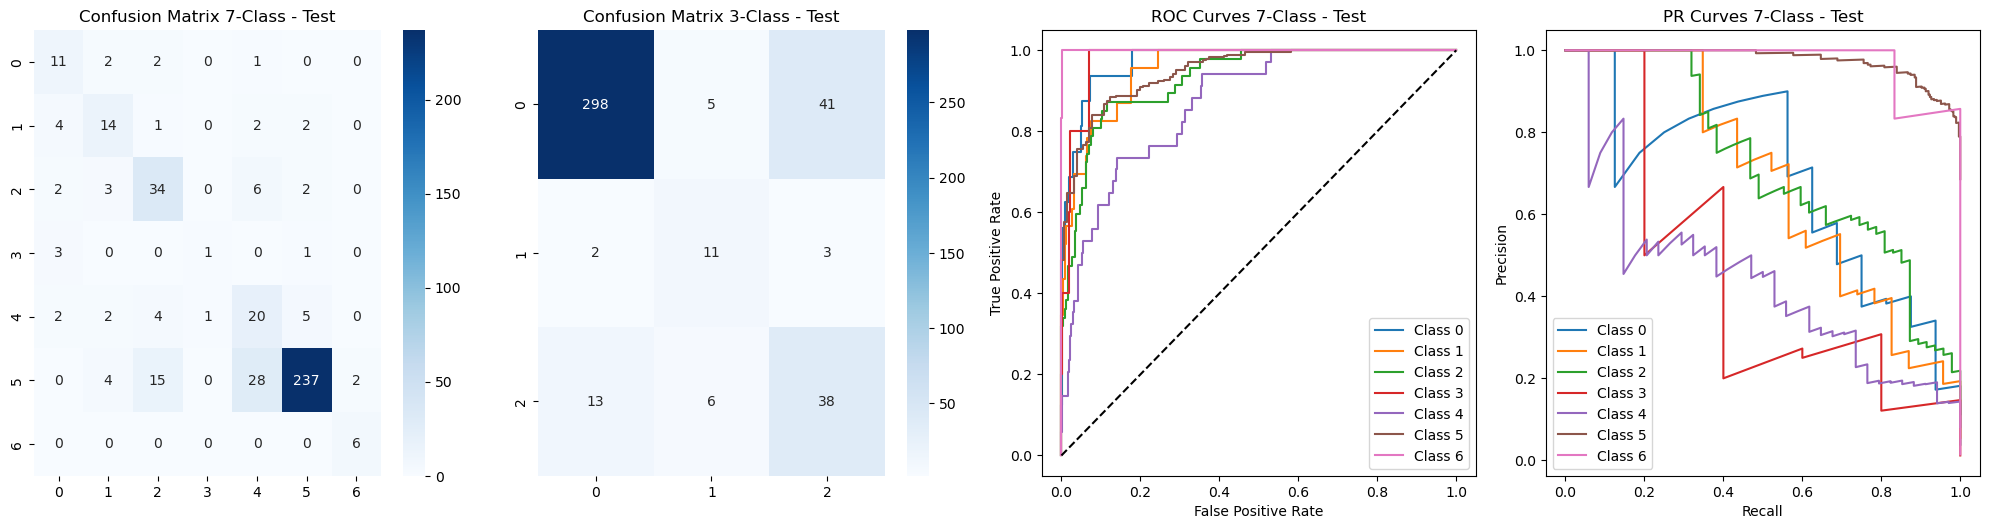

In [36]:
train_metrics = evaluate_pytorch_model(dual_model, X_img_train, X_tab_train, y_train_7, y_train_3, 'Train')
val_metrics = evaluate_pytorch_model(dual_model, X_img_val, X_tab_val, y_val_7, y_val_3, 'Validation')
test_metrics = evaluate_pytorch_model(dual_model, X_img_test, X_tab_test, y_test_7, y_test_3, 'Test')

final_results = pd.DataFrame([train_metrics, val_metrics, test_metrics])
final_results.to_csv('pytorch_comprehensive_7class_model_metrics.csv', index=False)



In [37]:
torch.save({
    'model_state_dict': dual_model.state_dict(),
    'optimizer_state_dict': optimizer_dual.state_dict(),
    'dx_encoder': dx_encoder,
    'ohe': ohe,
    'scaler': scaler_full
}, 'ham10000_pytorch_complete_model.pth')



In [38]:
import joblib


In [39]:
joblib.dump(scaler_full, 'pytorch_tabular_scaler.pkl')
joblib.dump(ohe, 'pytorch_localization_encoder.pkl')
joblib.dump(dx_encoder, 'pytorch_dx_encoder.pkl')


['pytorch_dx_encoder.pkl']

In [40]:
def load_and_test_finetuned_model():
    # Load the best fine-tuned model
    finetuned_model = DualInputModel(X_tabular_scaled.shape[1], 7).to(device)

    try:
        finetuned_model.load_state_dict(torch.load('best_dual_model_finetuned_final.pth', map_location=device))
        print("Fine-tuned model loaded successfully from 'best_dual_model_finetuned_final.pth'")
    except FileNotFoundError:
        try:
            finetuned_model.load_state_dict(torch.load('best_dual_model.pth', map_location=device))
            print("Loading from 'best_dual_model.pth' (backup)")
        except FileNotFoundError:
            print("No fine-tuned model found. Using current model state.")
            return dual_model

    finetuned_model.eval()

    test_batch_size = 16
    test_dataset = DualDataset(X_img_test[:test_batch_size], X_tab_test[:test_batch_size], y_test_7[:test_batch_size])
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

    with torch.no_grad():
        for images, tabular, labels in test_loader:
            images, tabular = images.to(device), tabular.to(device)
            outputs = finetuned_model(images, tabular)
            predictions = torch.argmax(outputs, dim=1)

            print(f"Model inference working. Output shape: {outputs.shape}")
            print(f"Sample predictions: {predictions[:5].cpu().numpy()}")
            print(f"Sample true labels: {labels[:5].numpy()}")
            break

    return finetuned_model



In [41]:
final_finetuned_model = load_and_test_finetuned_model()


/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fine-tuned model loaded successfully from 'best_dual_model_finetuned_final.pth'
Model inference working. Output shape: torch.Size([16, 7])
Sample predictions: [6 5 5 5 4]
Sample true labels: [5 5 5 5 5]


In [42]:
def comprehensive_model_evaluation(model, dataset_name="Fine-tuned Model"):
    print(f"\n{'='*60}")
    print(f"COMPREHENSIVE EVALUATION: {dataset_name}")
    print(f"{'='*60}")

    train_metrics = evaluate_pytorch_model(model, X_img_train, X_tab_train, y_train_7, y_train_3, 'Train')
    val_metrics = evaluate_pytorch_model(model, X_img_val, X_tab_val, y_val_7, y_val_3, 'Validation')
    test_metrics = evaluate_pytorch_model(model, X_img_test, X_tab_test, y_test_7, y_test_3, 'Test')

    results_df = pd.DataFrame([train_metrics, val_metrics, test_metrics])

    print(f"\n{'PERFORMANCE SUMMARY':<25} {'Train':<10} {'Validation':<12} {'Test':<10}")
    print("-" * 60)
    print(f"{'7-Class Accuracy':<25} {results_df.loc[0, 'accuracy_7class']:<10.3f} {results_df.loc[1, 'accuracy_7class']:<12.3f} {results_df.loc[2, 'accuracy_7class']:<10.3f}")
    print(f"{'3-Class Accuracy':<25} {results_df.loc[0, 'accuracy_3class']:<10.3f} {results_df.loc[1, 'accuracy_3class']:<12.3f} {results_df.loc[2, 'accuracy_3class']:<10.3f}")
    print(f"{'7-Class F1 Macro':<25} {results_df.loc[0, 'f1_macro_7class']:<10.3f} {results_df.loc[1, 'f1_macro_7class']:<12.3f} {results_df.loc[2, 'f1_macro_7class']:<10.3f}")
    print(f"{'3-Class F1 Macro':<25} {results_df.loc[0, 'f1_macro_3class']:<10.3f} {results_df.loc[1, 'f1_macro_3class']:<12.3f} {results_df.loc[2, 'f1_macro_3class']:<10.3f}")
    print(f"{'7-Class AUC Macro':<25} {results_df.loc[0, 'auc_macro_7class']:<10.3f} {results_df.loc[1, 'auc_macro_7class']:<12.3f} {results_df.loc[2, 'auc_macro_7class']:<10.3f}")

    results_df.to_csv(f'{dataset_name.lower().replace(" ", "_")}_comprehensive_metrics.csv', index=False)
    print(f"\nResults saved to '{dataset_name.lower().replace(' ', '_')}_comprehensive_metrics.csv'")

    return results_df




COMPREHENSIVE EVALUATION: Fine-tuned Model


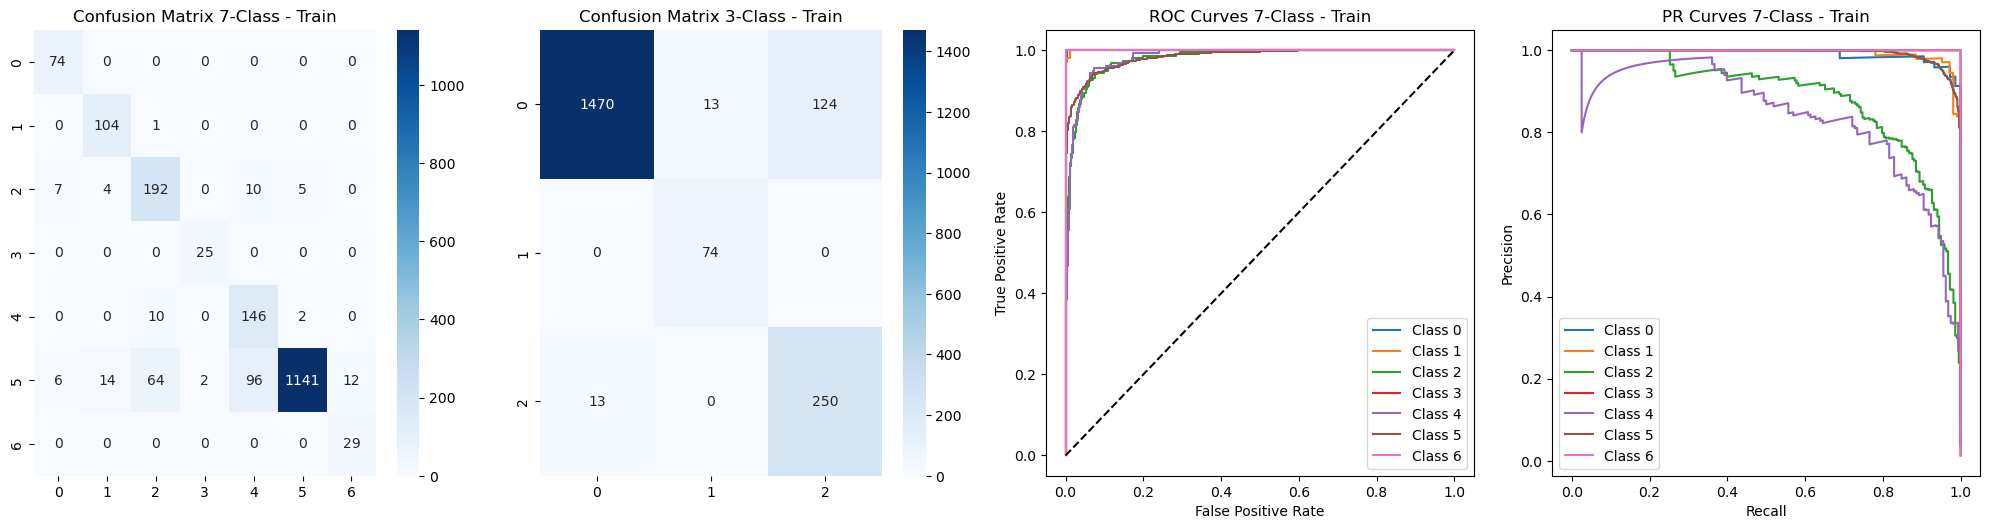

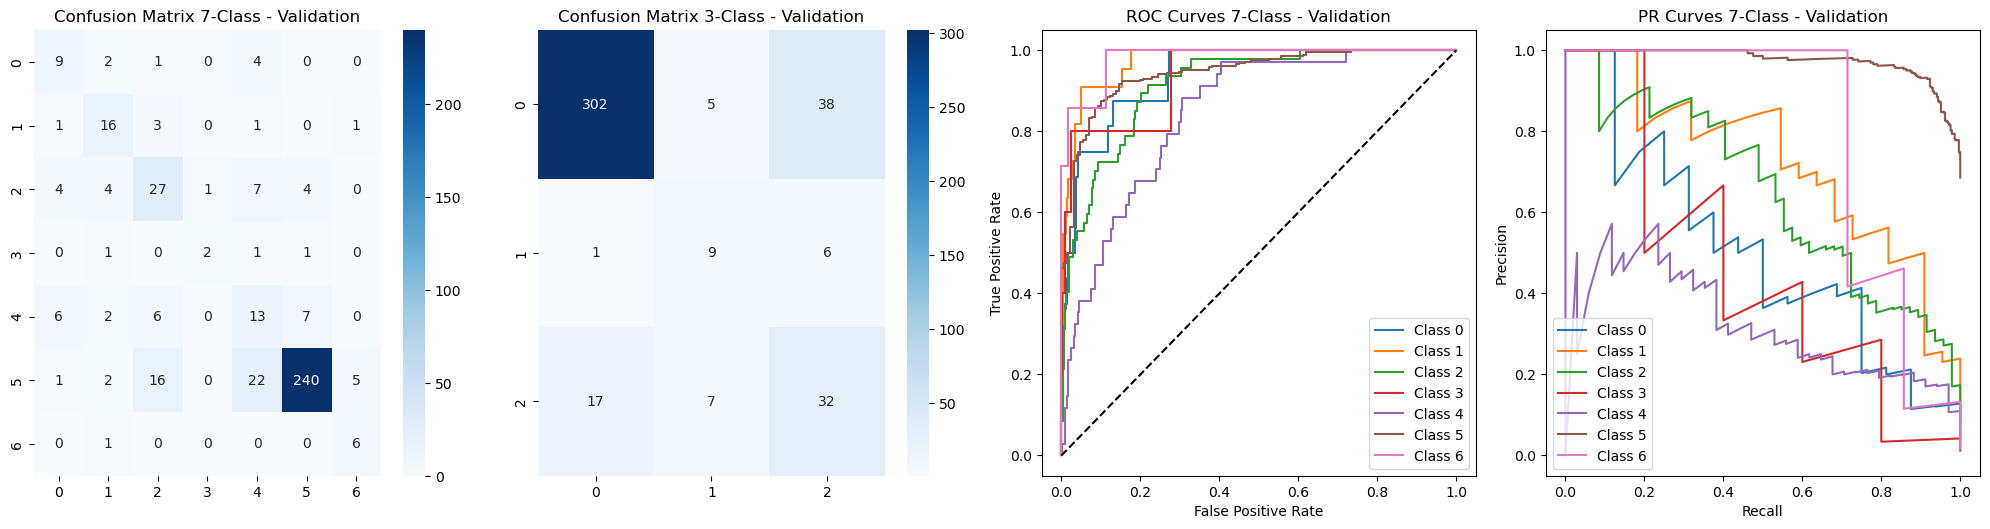

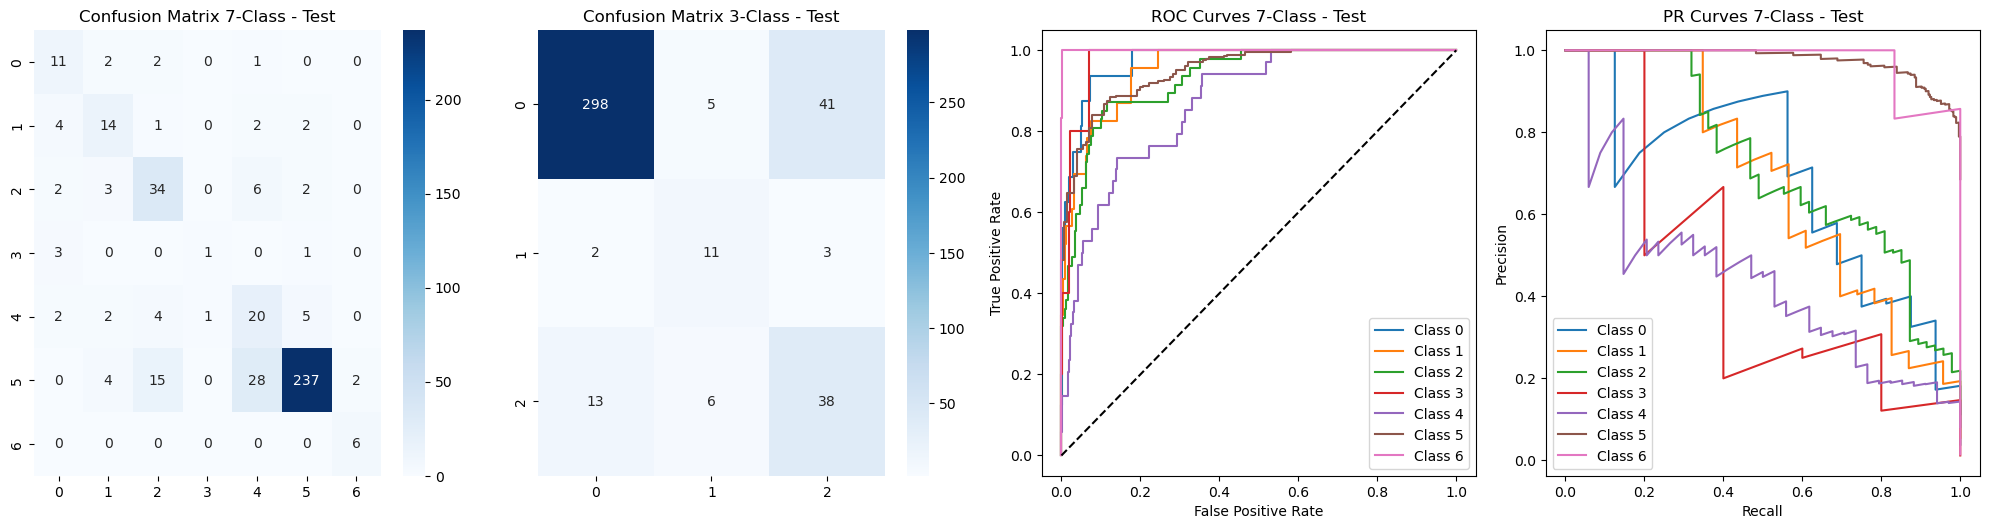


PERFORMANCE SUMMARY       Train      Validation   Test      
------------------------------------------------------------
7-Class Accuracy          0.880      0.751        0.775     
3-Class Accuracy          0.923      0.823        0.832     
7-Class F1 Macro          0.864      0.572        0.613     
3-Class F1 Macro          0.885      0.627        0.678     
7-Class AUC Macro         0.992      0.933        0.951     

Results saved to 'fine-tuned_model_comprehensive_metrics.csv'


In [43]:
final_results_finetuned = comprehensive_model_evaluation(final_finetuned_model, "Fine-tuned Model")



MODEL COMPARISON: Original vs Fine-tuned
Original model loaded from 'best_dual_model.pth'


/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fine-tuned model loaded from 'best_dual_model_finetuned_final.pth'

Evaluating original model...


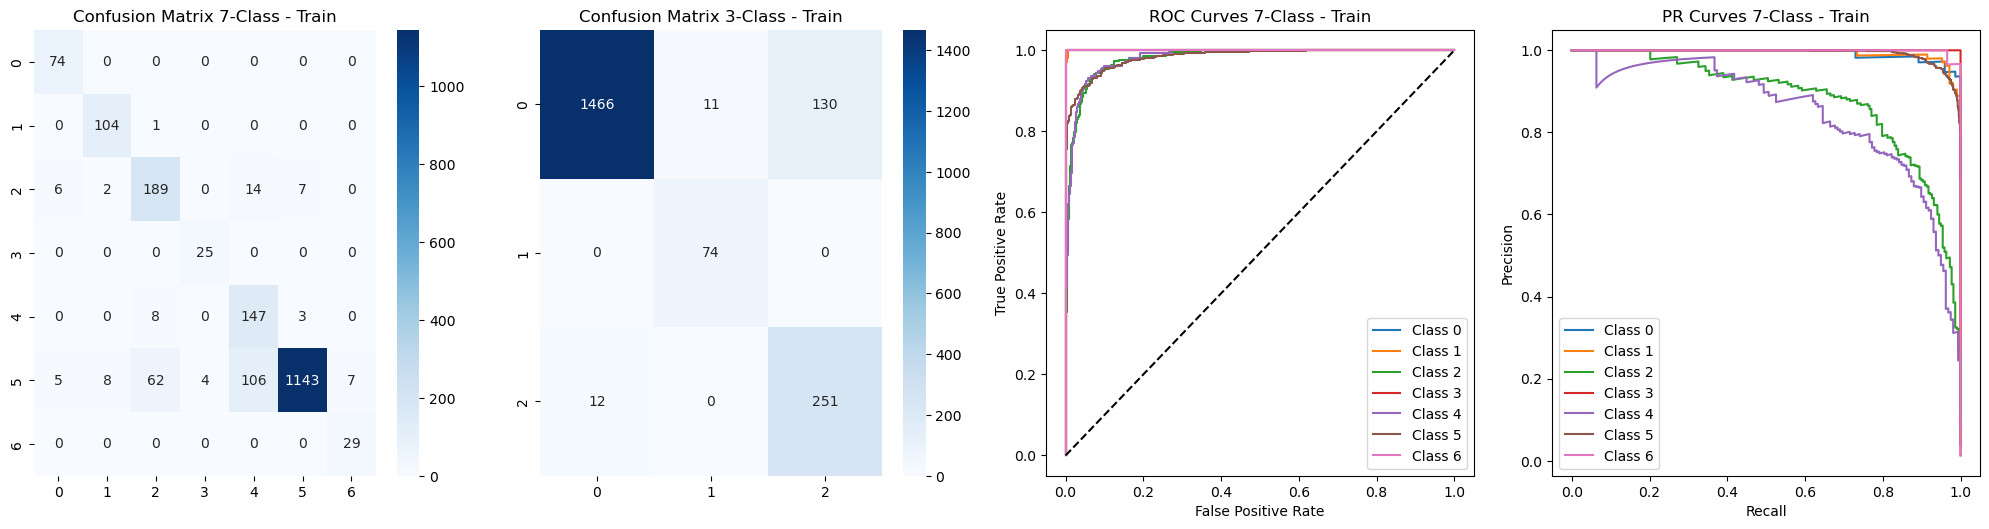

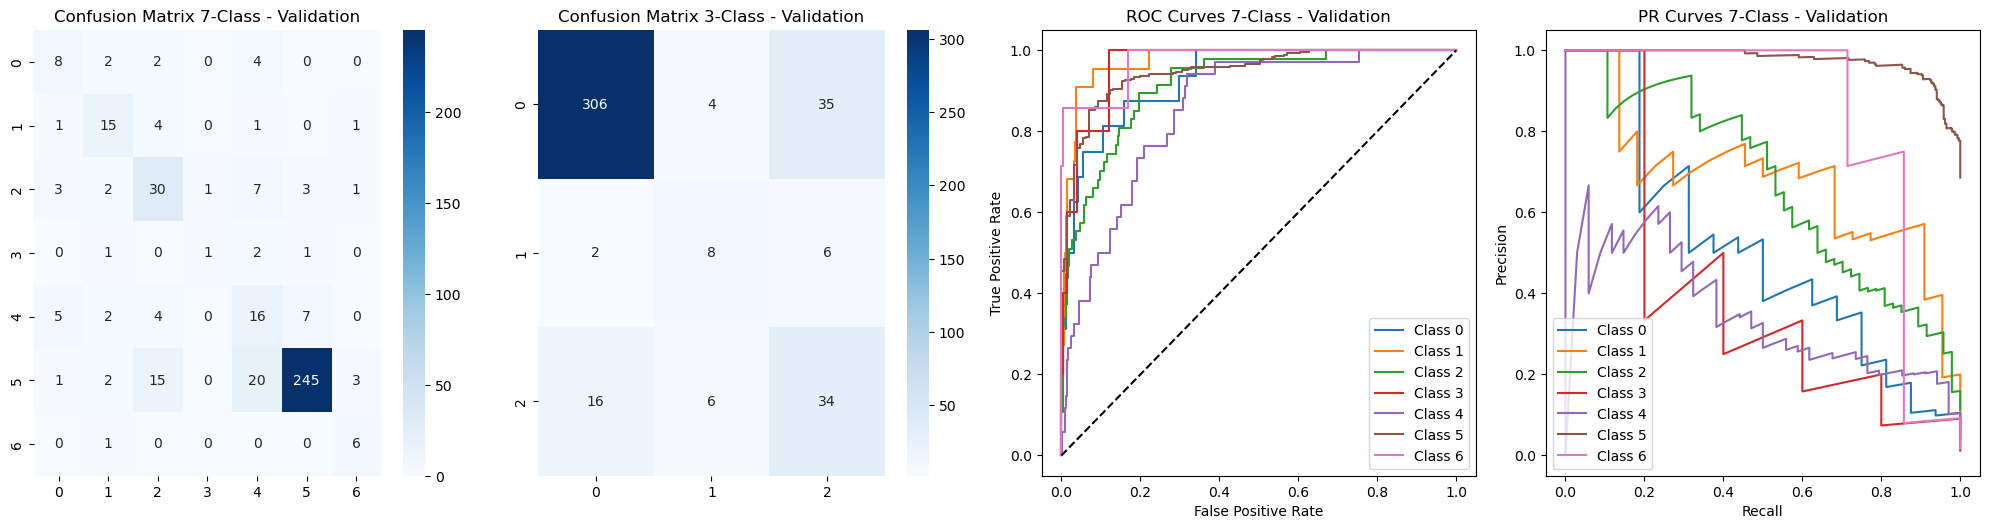

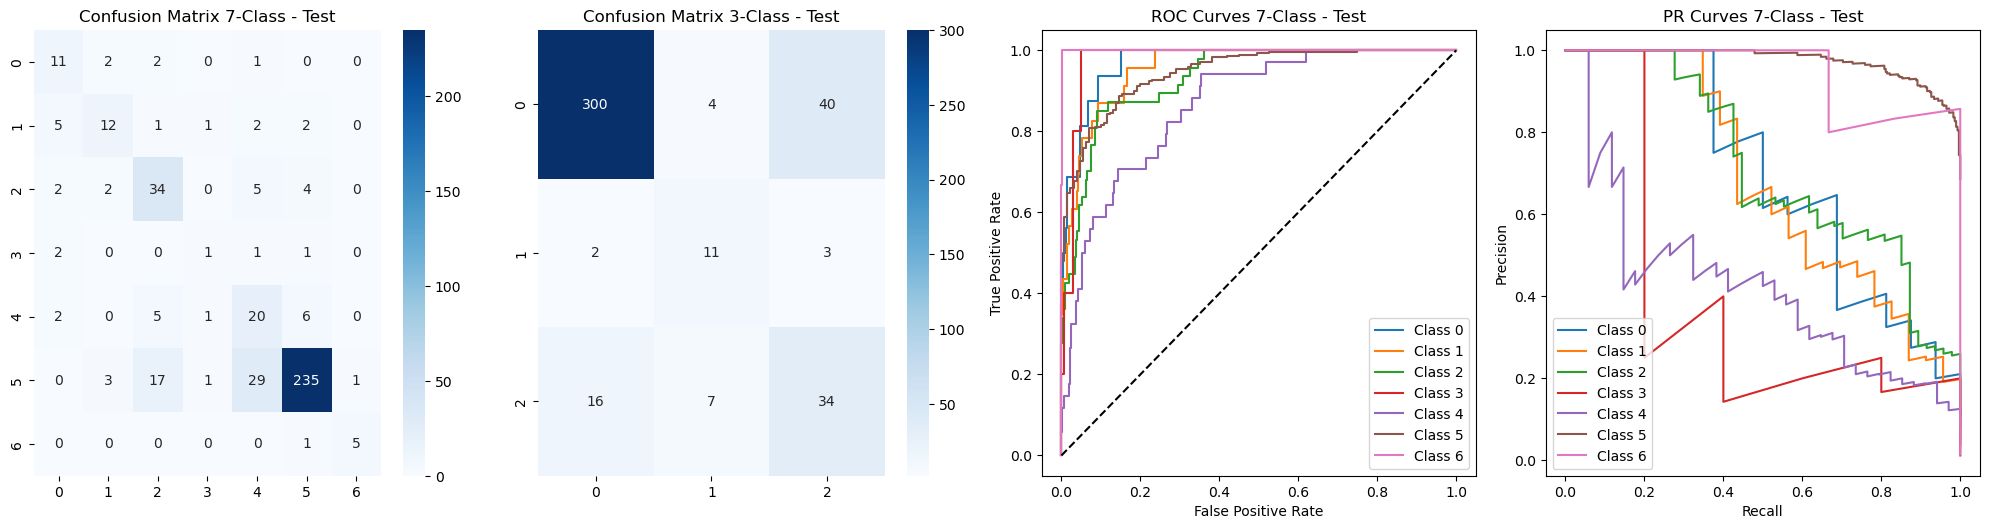


Evaluating fine-tuned model...


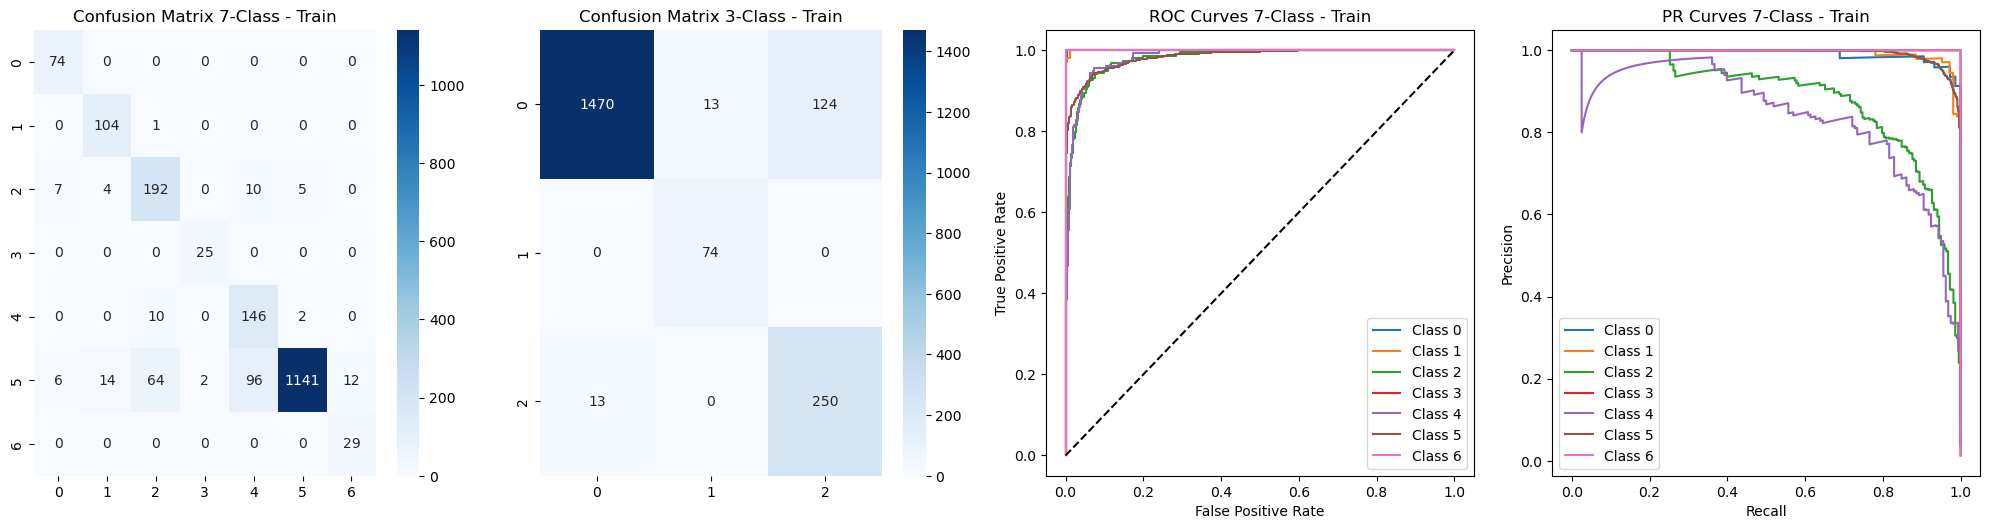

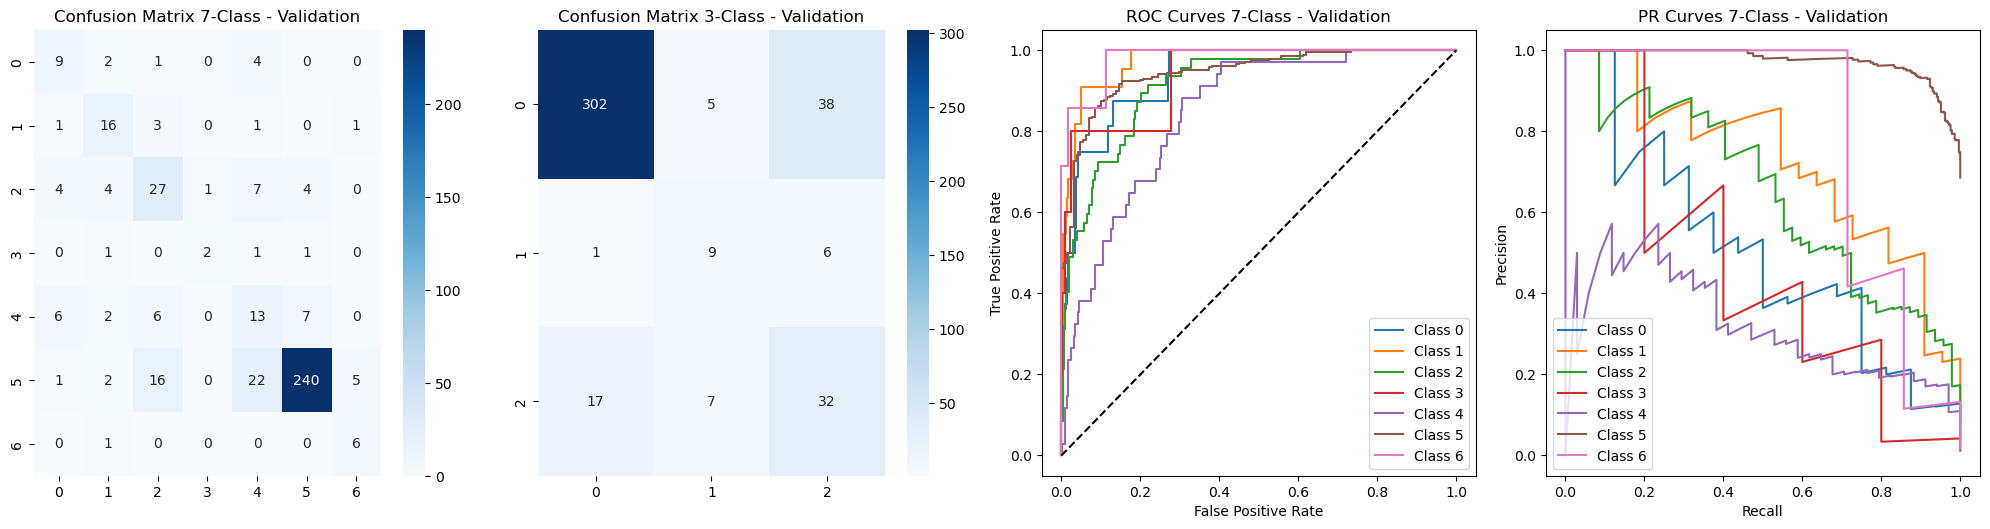

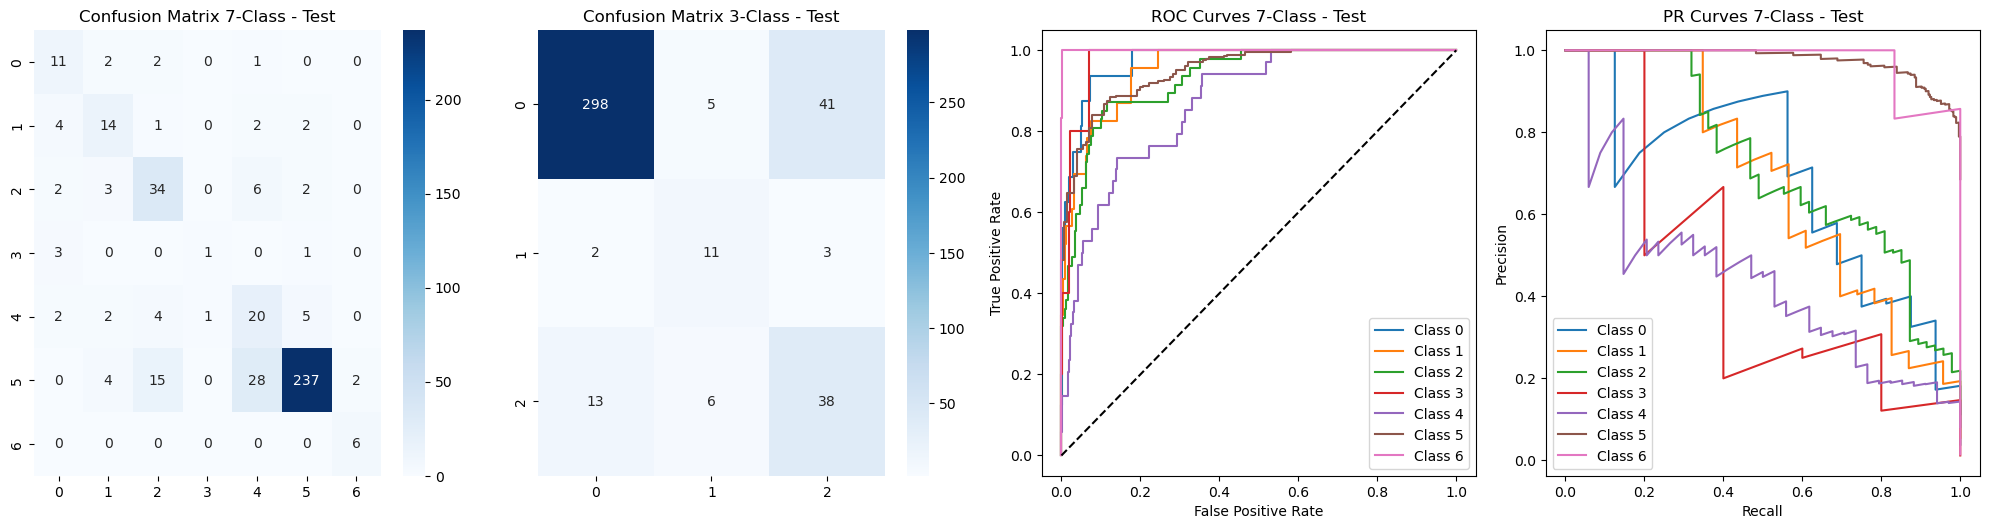


TRAIN SET COMPARISON:
----------------------------------------------------------------------
Metric                    Original     Fine-tuned   Improvement    
----------------------------------------------------------------------
Accuracy 7Class           0.880        0.880          +0.000 (  +0.0%)
Accuracy 3Class           0.921        0.923          +0.002 (  +0.2%)
F1 Macro 7Class           0.871        0.864          -0.007 (  -0.8%)
F1 Macro 3Class           0.887        0.885          -0.002 (  -0.2%)
Auc Macro 7Class          0.992        0.992          -0.000 (  -0.0%)

VALIDATION SET COMPARISON:
----------------------------------------------------------------------
Metric                    Original     Fine-tuned   Improvement    
----------------------------------------------------------------------
Accuracy 7Class           0.770        0.751          -0.019 (  -2.5%)
Accuracy 3Class           0.835        0.823          -0.012 (  -1.4%)
F1 Macro 7Class           0.562 

In [50]:
def compare_models_from_files():
    print(f"\n{'='*80}")
    print("MODEL COMPARISON: Original vs Fine-tuned")
    print(f"{'='*80}")
    
    # Load original model (from initial training)
    original_model = DualInputModel(X_tabular_scaled.shape[1], 7).to(device)
    try:
        original_model.load_state_dict(torch.load('best_dual_model.pth', map_location=device))
        print("Original model loaded from 'best_dual_model.pth'")
    except FileNotFoundError:
        print("Original model file not found!")
        return
    
    # Load fine-tuned model
    finetuned_model = DualInputModel(X_tabular_scaled.shape[1], 7).to(device)
    try:
        finetuned_model.load_state_dict(torch.load('best_dual_model_finetuned_final.pth', map_location=device))
        print("Fine-tuned model loaded from 'best_dual_model_finetuned_final.pth'")
    except FileNotFoundError:
        print("Fine-tuned model file not found!")
        return
    
    # Evaluate original model
    print("\nEvaluating original model...")
    orig_train = evaluate_pytorch_model(original_model, X_img_train, X_tab_train, y_train_7, y_train_3, 'Train')
    orig_val = evaluate_pytorch_model(original_model, X_img_val, X_tab_val, y_val_7, y_val_3, 'Validation')
    orig_test = evaluate_pytorch_model(original_model, X_img_test, X_tab_test, y_test_7, y_test_3, 'Test')
    original_results = pd.DataFrame([orig_train, orig_val, orig_test])
    
    print("\nEvaluating fine-tuned model...")
    fine_train = evaluate_pytorch_model(finetuned_model, X_img_train, X_tab_train, y_train_7, y_train_3, 'Train')
    fine_val = evaluate_pytorch_model(finetuned_model, X_img_val, X_tab_val, y_val_7, y_val_3, 'Validation')
    fine_test = evaluate_pytorch_model(finetuned_model, X_img_test, X_tab_test, y_test_7, y_test_3, 'Test')
    finetuned_results = pd.DataFrame([fine_train, fine_val, fine_test])
    
    comparison_metrics = ['accuracy_7class', 'accuracy_3class', 'f1_macro_7class', 'f1_macro_3class', 'auc_macro_7class']
    splits = ['Train', 'Validation', 'Test']

    for split_idx, split in enumerate(splits):
        print(f"\n{split.upper()} SET COMPARISON:")
        print("-" * 70)
        print(f"{'Metric':<25} {'Original':<12} {'Fine-tuned':<12} {'Improvement':<15}")
        print("-" * 70)

        for metric in comparison_metrics:
            orig_val = original_results.loc[split_idx, metric]
            fine_val = finetuned_results.loc[split_idx, metric]
            improvement = fine_val - orig_val
            improvement_pct = (improvement / orig_val) * 100 if orig_val != 0 else 0

            print(f"{metric.replace('_', ' ').title():<25} {orig_val:<12.3f} {fine_val:<12.3f} {improvement:>+8.3f} ({improvement_pct:+6.1f}%)")

compare_models_from_files()


In [51]:
def plot_enhanced_training_metrics(
    dual_train_losses, dual_val_losses, dual_val_accuracies,
    finetune_train_losses=None, finetune_val_losses=None, finetune_val_accuracies=None,
    metadata=None, final_results=None
):
    fig = plt.figure(figsize=(28, 20))

    plt.subplot(4, 4, 1)
    epochs_initial = range(1, len(dual_train_losses) + 1)
    plt.plot(epochs_initial, dual_train_losses, 'b-', linewidth=2, label='Training Loss', alpha=0.8)
    plt.plot(epochs_initial, dual_val_losses, 'r-', linewidth=2, label='Validation Loss', alpha=0.8)
    plt.title('Initial Training Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.subplot(4, 4, 2)
    plt.plot(epochs_initial, dual_val_accuracies, 'g-', linewidth=2, label='Validation Accuracy', alpha=0.8)
    plt.title('Initial Training Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.subplot(4, 4, 3)
    if finetune_train_losses and finetune_val_losses:
        epochs_finetune = range(1, len(finetune_train_losses) + 1)
        plt.plot(epochs_finetune, finetune_train_losses, 'b--', linewidth=2, label='Fine-tune Train Loss', alpha=0.8)
        plt.plot(epochs_finetune, finetune_val_losses, 'r--', linewidth=2, label='Fine-tune Val Loss', alpha=0.8)
    plt.title('Fine-tuning Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.subplot(4, 4, 4)
    if finetune_val_accuracies:
        epochs_finetune = range(1, len(finetune_val_accuracies) + 1)
        plt.plot(epochs_finetune, finetune_val_accuracies, 'g--', linewidth=2, label='Fine-tune Val Accuracy', alpha=0.8)
    plt.title('Fine-tuning Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)

    plt.subplot(4, 4, 5)
    age_cancer_risk = metadata.groupby('age_group')['cancer_category'].apply(lambda x: (x > 0).mean())
    bars = plt.bar(range(len(age_cancer_risk)), age_cancer_risk.values, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Cancer Risk by Age Group', fontsize=14, fontweight='bold')
    plt.ylabel('Risk Proportion', fontsize=12)
    plt.xlabel('Age Group', fontsize=12)
    plt.xticks(range(len(age_cancer_risk)), age_cancer_risk.index, rotation=45)

    for bar, value in zip(bars, age_cancer_risk.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.2f}',
                ha='center', va='bottom', fontsize=10)

    plt.subplot(4, 4, 6)
    localization_risk = metadata.groupby('localization')['cancer_category'].apply(lambda x: (x > 0).mean()).sort_values(ascending=False)
    top_10_loc = localization_risk.head(10)
    bars = plt.bar(range(len(top_10_loc)), top_10_loc.values, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.title('Top 10 High-Risk Localizations', fontsize=14, fontweight='bold')
    plt.ylabel('Cancer Risk Proportion', fontsize=12)
    plt.xlabel('Localization', fontsize=12)
    plt.xticks(range(len(top_10_loc)), [loc[:8] + '...' if len(loc) > 8 else loc for loc in top_10_loc.index], rotation=45)

    plt.subplot(4, 4, 7)
    dx_age_mean = metadata.groupby('dx')['age'].mean().sort_values()
    bars = plt.bar(range(len(dx_age_mean)), dx_age_mean.values, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title('Mean Age by Diagnosis', fontsize=14, fontweight='bold')
    plt.ylabel('Mean Age', fontsize=12)
    plt.xlabel('Diagnosis', fontsize=12)
    plt.xticks(range(len(dx_age_mean)), dx_age_mean.index, rotation=45)

    plt.subplot(4, 4, 8)
    sex_dx_crosstab = pd.crosstab(metadata['dx'], metadata['sex'], normalize='columns')
    sex_dx_crosstab.plot(kind='bar', stacked=True, rot=45, ax=plt.gca(), alpha=0.8)
    plt.title('Diagnosis Distribution by Sex', fontsize=14, fontweight='bold')
    plt.xlabel('Diagnosis', fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.legend(['Female', 'Male/Unknown'], fontsize=10)

    plt.subplot(4, 4, 9)
    wedges, texts, autotexts = plt.pie(metadata['dx'].value_counts().values,
                                       labels=metadata['dx'].value_counts().index,
                                       autopct='%1.1f%%', startangle=90)
    plt.title('Overall Diagnosis Distribution', fontsize=14, fontweight='bold')

    plt.subplot(4, 4, 10)
    age_dx_heatmap = pd.crosstab(metadata['age_group'], metadata['dx'])
    sns.heatmap(age_dx_heatmap, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'shrink': 0.8})
    plt.title('Age Group vs Diagnosis Heatmap', fontsize=14, fontweight='bold')
    plt.xlabel('Diagnosis', fontsize=12)
    plt.ylabel('Age Group', fontsize=12)

    plt.subplot(4, 4, 11)
    x_pos = np.arange(len(final_results))
    width = 0.35
    plt.bar(x_pos - width/2, final_results['accuracy_7class'], width, label='7-class', alpha=0.8, color='steelblue')
    plt.bar(x_pos + width/2, final_results['accuracy_3class'], width, label='3-class', alpha=0.8, color='orange')
    plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Dataset Split', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(x_pos, ['Train', 'Validation', 'Test'])
    plt.legend(fontsize=10)

    for i, (acc7, acc3) in enumerate(zip(final_results['accuracy_7class'], final_results['accuracy_3class'])):
        plt.text(i - width/2, acc7 + 0.01, f'{acc7:.3f}', ha='center', va='bottom', fontsize=9)
        plt.text(i + width/2, acc3 + 0.01, f'{acc3:.3f}', ha='center', va='bottom', fontsize=9)

    plt.subplot(4, 4, 12)
    plt.bar(x_pos - width/2, final_results['f1_macro_7class'], width, label='7-class', alpha=0.8, color='forestgreen')
    plt.bar(x_pos + width/2, final_results['f1_macro_3class'], width, label='3-class', alpha=0.8, color='gold')
    plt.title('Model F1 Score Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Dataset Split', fontsize=12)
    plt.ylabel('F1 Score', fontsize=12)
    plt.xticks(x_pos, ['Train', 'Validation', 'Test'])
    plt.legend(fontsize=10)

    for i, (f17, f13) in enumerate(zip(final_results['f1_macro_7class'], final_results['f1_macro_3class'])):
        plt.text(i - width/2, f17 + 0.01, f'{f17:.3f}', ha='center', va='bottom', fontsize=9)
        plt.text(i + width/2, f13 + 0.01, f'{f13:.3f}', ha='center', va='bottom', fontsize=9)

    plt.subplot(4, 4, (13, 16))
    all_train_losses = dual_train_losses.copy()
    all_val_losses = dual_val_losses.copy()
    all_val_accuracies = dual_val_accuracies.copy()

    if finetune_train_losses:
        all_train_losses.extend(finetune_train_losses)
        all_val_losses.extend(finetune_val_losses)
        all_val_accuracies.extend(finetune_val_accuracies)

    epochs_all = range(1, len(all_train_losses) + 1)

    ax1 = plt.gca()
    ax2 = ax1.twinx()

    line1 = ax1.plot(epochs_all, all_train_losses, 'b-', linewidth=2, label='Training Loss', alpha=0.8)
    line2 = ax1.plot(epochs_all, all_val_losses, 'r-', linewidth=2, label='Validation Loss', alpha=0.8)
    line3 = ax2.plot(epochs_all, all_val_accuracies, 'g-', linewidth=2, label='Validation Accuracy', alpha=0.8)

    ax1.set_xlabel('Epoch', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14, color='black')
    ax2.set_ylabel('Accuracy (%)', fontsize=14, color='green')

    if finetune_train_losses:
        ax1.axvline(x=len(dual_train_losses), color='purple', linestyle='--', alpha=0.7, linewidth=2)
        ax1.text(len(dual_train_losses), max(all_train_losses)*0.8, 'Fine-tuning\nStarts',
                rotation=90, fontsize=10, ha='right', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="purple", alpha=0.3))

    plt.title('Complete Training Progression', fontsize=16, fontweight='bold', pad=20)

    lines = line1 + line2 + line3
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right', fontsize=12)

    ax1.grid(True, alpha=0.3)

    plt.tight_layout(pad=3.0)
    plt.show()



/tmp/ipykernel_209/2918871582.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_cancer_risk = metadata.groupby('age_group')['cancer_category'].apply(lambda x: (x > 0).mean())


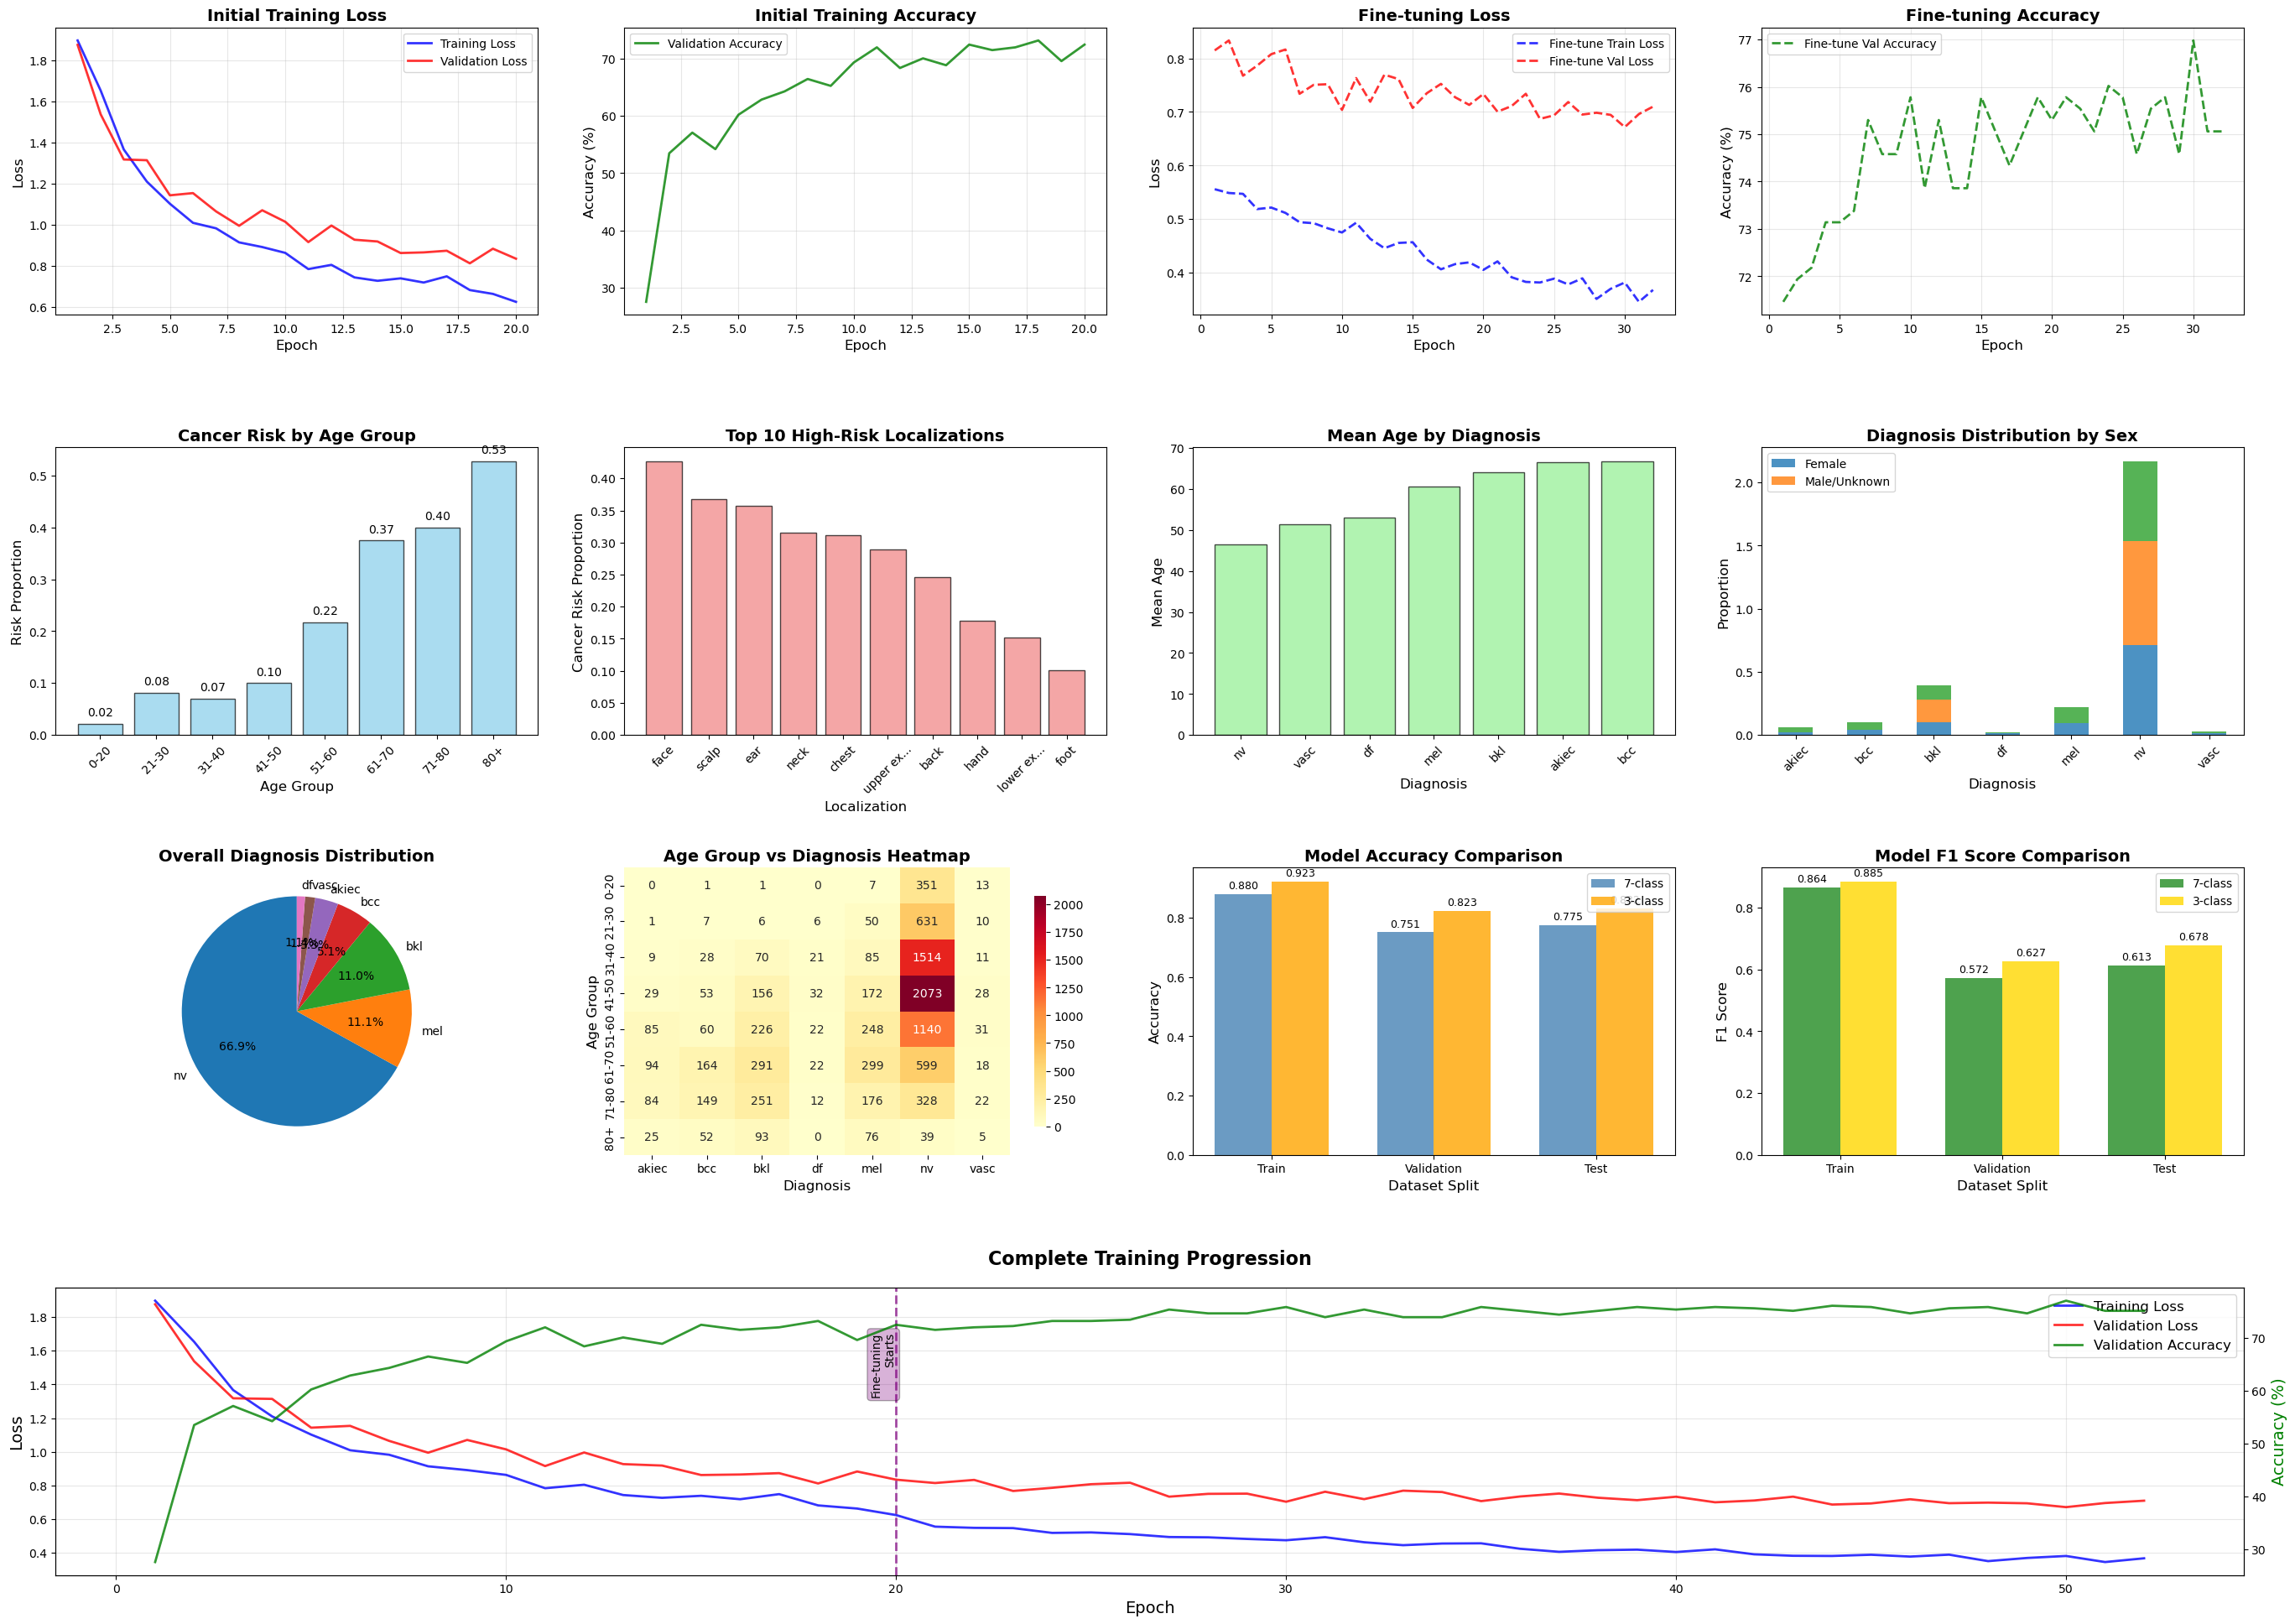

In [52]:
plot_enhanced_training_metrics(
    dual_train_losses,
    dual_val_losses,
    dual_val_accuracies,
    finetune_train_losses,
    finetune_val_losses,
    finetune_val_accuracies,
    metadata,
    final_results_finetuned
)


In [53]:
def final_model_summary():
    print(f"\n{'='*80}")
    print("FINAL MODEL SUMMARY")
    print(f"{'='*80}")

    model_files = [
        'best_dual_model_finetuned_final.pth',
        'best_dual_model.pth',
        'best_stage_1_model.pth',
        'best_stage_2_model.pth',
        'best_stage_3_model.pth',
        'best_stage_4_model.pth'
    ]

    print("Saved Models:")
    for model_file in model_files:
        if os.path.exists(model_file):
            file_size = os.path.getsize(model_file) / (1024 * 1024)  # MB
            print(f"{model_file:<35} ({file_size:.1f} MB)")
        else:
            print(f"{model_file:<35} (not found)")

    print(f"\nDatasets and Encoders:")
    pickle_files = [
        'pytorch_tabular_scaler.pkl',
        'pytorch_localization_encoder.pkl',
        'pytorch_dx_encoder.pkl'
    ]

    for pickle_file in pickle_files:
        if os.path.exists(pickle_file):
            print(f"{pickle_file}")
        else:
            print(f"{pickle_file}")

    print(f"\nModel Architecture:")
    print(f"  - Base Model: EfficientNet-B0 (pretrained)")
    print(f"  - Image Features: 1280 → 256")
    print(f"  - Tabular Features: {X_tabular_scaled.shape[1]} → 32")
    print(f"  - Combined Features: 288 → 128 → 7 classes")
    print(f"  - Total Parameters: {sum(p.numel() for p in final_finetuned_model.parameters()):,}")
    print(f"  - Trainable Parameters: {sum(p.numel() for p in final_finetuned_model.parameters() if p.requires_grad):,}")

    print(f"\nDataset Information:")
    print(f"  - Total Samples: {len(X_images):,}")
    print(f"  - Training: {len(X_img_train):,} ({len(X_img_train)/len(X_images)*100:.1f}%)")
    print(f"  - Validation: {len(X_img_val):,} ({len(X_img_val)/len(X_images)*100:.1f}%)")
    print(f"  - Test: {len(X_img_test):,} ({len(X_img_test)/len(X_images)*100:.1f}%)")
    print(f"  - Classes: 7 (dx) → 3 (cancer categories)")

final_model_summary()



FINAL MODEL SUMMARY
Saved Models:
best_dual_model_finetuned_final.pth (17.0 MB)
best_dual_model.pth                 (17.0 MB)
best_stage_1_model.pth              (17.0 MB)
best_stage_2_model.pth              (17.0 MB)
best_stage_3_model.pth              (17.0 MB)
best_stage_4_model.pth              (17.0 MB)

Datasets and Encoders:
pytorch_tabular_scaler.pkl
pytorch_localization_encoder.pkl
pytorch_dx_encoder.pkl

Model Architecture:
  - Base Model: EfficientNet-B0 (pretrained)
  - Image Features: 1280 → 256
  - Tabular Features: 17 → 32
  - Combined Features: 288 → 128 → 7 classes
  - Total Parameters: 4,376,611
  - Trainable Parameters: 369,063

Dataset Information:
  - Total Samples: 2,778
  - Training: 1,944 (70.0%)
  - Validation: 417 (15.0%)
  - Test: 417 (15.0%)
  - Classes: 7 (dx) → 3 (cancer categories)
